# Final Project: Daily Visits to Website
File: website_traffic_data.csv

This dataset records data related to website traffic. 

## 1.0 Preparing Jupyter Notebook

### Package Downloads

In [1]:
#Import necessary packages and set options for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings

### Jupyter Notebook Settings

In [2]:
#Set the maximum number of rows that can be observed
pd.set_option('display.max_rows', 45)
pd.set_option('display.max_columns',100)

### Function Creation

In [3]:
#Create a function that is going to plot data 
#It is called time series because that is the type of data it is going to be primarily be dealing with
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [4]:
#Create a scatterplot graph
def scatter(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(14,6))
    plt.scatter(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [5]:
#Create a seasonal decomposition of the different parts that make up the data
#Creating a subplot where the values are stacked up on one another makes it easier to read

def plot_seasonal_decomposition(data, period):
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
#Create a rolling mean of the data to understand the trend

def roll_mean(df_column,window,title,xlabel,ylabel):

    plt.figure(figsize=(10,6))
    rolmean = df_column.rolling(window).mean()

    # Plot the original data and the rolling mean
    plt.figure(figsize=(10, 6))
    plt.plot(df_column, color='blue', label='Original')
    plt.plot(rolmean, color='red', label=f'Rolling Mean (window={window})')

    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add legend and display plot
    plt.legend(loc='best')
    plt.show()

In [7]:
#Get the decomposed values which make up the time series
def decompose_seasonality(data, period):    

    decomposition = seasonal_decompose(data, period=period)

    original = data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return original, trend, seasonal, residual

In [8]:
#Create a least squares line going through the data values

def plot_least_squares_line(x_value, y_value, title, x_label, y_label):
    plt.figure(figsize=(10,6))
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Predicting y values using the model
    y_pred = model.predict(x)

    # Plotting the original data and the least squares line
    plt.plot(x, y, label='original data', color='blue')
    plt.plot(x, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [9]:
#Create the Dickey Fuller test to use on data
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [10]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [ ]:
from pmdarima import auto_arima

def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Fits a SARIMA model to the provided data, searching over given parameter lists.
    It returns the best model based on AIC and also provides its BIC for comparison.
   
    Parameters:
    - data: Pandas Series of the time series data.
    - p_list, d_list, q_list: Lists of integers for the AR (p), differencing (d), and MA (q) parameters.
    - P_list, D_list, Q_list: Lists of integers for the seasonal AR (P), seasonal differencing (D),
                              and seasonal MA (Q) parameters.
    - s: Integer representing the length of the seasonal cycle.
   
    Returns:
    - A dictionary with the best model's AIC and BIC, along with the corresponding parameters.
    """
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

## 1.1 Data Preprocessing:
1. Load the dataset and convert the date information into a datetime object to facilitate time series analysis.

2. Check for missing values and anomalies, and handle them appropriately.

### Import data

In [11]:
#Import the data and save it as website
website = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Applied Statistics & Modeling/Final Project/Data Files/website_traffic_data.csv')
website

,Date,Daily_Visitors
0,2020-01-01,202
1,2020-01-02,204
2,2020-01-03,197
3,2020-01-04,197
4,2020-01-05,239
...,...,...
1456,2023-12-27,185
1457,2023-12-28,202
1458,2023-12-29,234
1459,2023-12-30,194


### Preprocess dataframe

In [12]:
#Rename column 'Daily_Visitors' to 'Daily Visitors'
website.rename(columns={'Daily_Visitors': 'Daily Visitors'}, inplace=True)

In [13]:
#Set the 'Date' column to datetime
website['Date'] = pd.to_datetime(website['Date'])

In [14]:
#Set the index to the 'Date' column
website.set_index('Date',inplace=True)
website

,Daily Visitors
Date,
2020-01-01,202
2020-01-02,204
2020-01-03,197
2020-01-04,197
2020-01-05,239
...,...
2023-12-27,185
2023-12-28,202
2023-12-29,234


In [44]:
#Double check the columns are in the right format
#Expect '<M8[ns]' for index
#Expect 'float64' or 'int64' for monthly mean
print('Date dtype: ',website.index.dtype)
print('')
print('Daily Visitors dtype: ',website['Daily Visitors'].dtype)

Date dtype:  datetime64[ns]

Daily Visitors dtype:  int64


### Check for Missing Values

In [16]:
#Use isna is to create a series of true and false
#sum those to get a total number of missing values
#if it is 0 you can continue
website['Daily Visitors'].isna().sum()

0

### Check for Anomalies
There are a number of ways to do this. I am going to use the statistical way by creating z scores and see if any of them lie outside of this

In [17]:
#Create zscore value
website['zscore'] = (website['Daily Visitors'] - website['Daily Visitors'].mean()) / website['Daily Visitors'].std()

#Identify anomalies where their standard deviation is greater than 3
anomalies = website[abs(website['zscore']) > 3]

if len(anomalies) == 0:
    print("No anomalies detected.")
else:
    print("Anomalies detected:")
    print(anomalies)

Anomalies detected:
            Daily Visitors    zscore
Date                                
2022-05-17             249  3.332062


This data only has one anomaly so there is no need to delete the value with a high zscore

### Plot the scatterplot graph

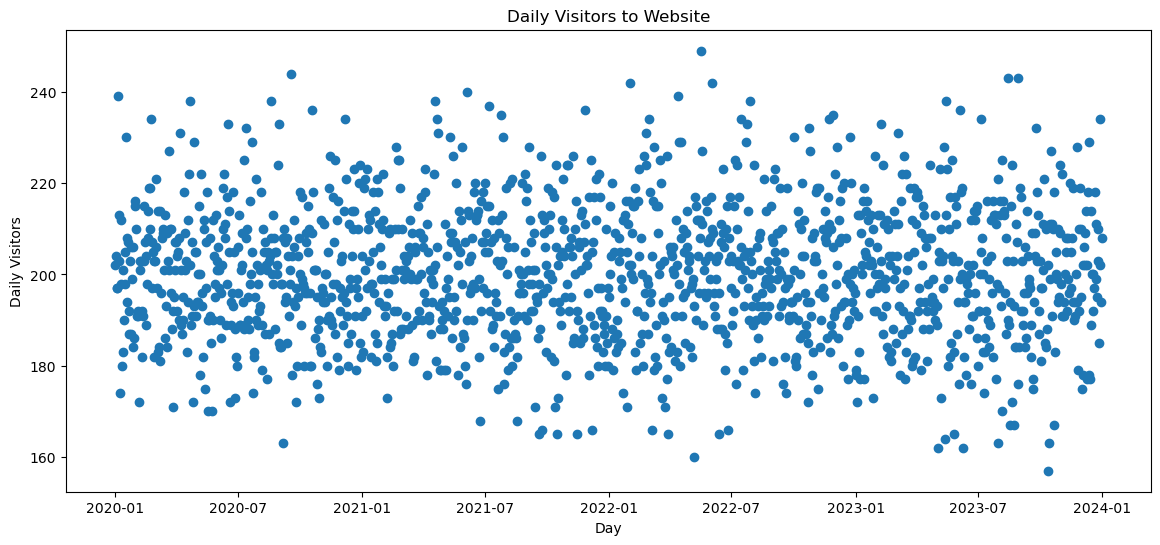

In [18]:
#Find the scatterplot 
scatter(website.index,website['Daily Visitors'],'Daily Visitors to Website','Year','Daily Visitors')

### Aggregate data

In [19]:
#Create a dataframe which adds the day values based on the month
website_monthly_sum = website.groupby(pd.Grouper(freq='M')).sum()
website_monthly_sum.index= website_monthly_sum.index - pd.offsets.MonthBegin(1)
website_monthly_sum

,Daily Visitors,zscore
Date,,
2020-01-01,6216,0.468965
2020-02-01,5845,2.493311
2020-03-01,6217,0.537378
2020-04-01,6056,3.225673
2020-05-01,6113,-6.577590
...,...,...
2023-08-01,6197,-0.830885
2023-09-01,5976,-2.247379
2023-10-01,6153,-3.841064


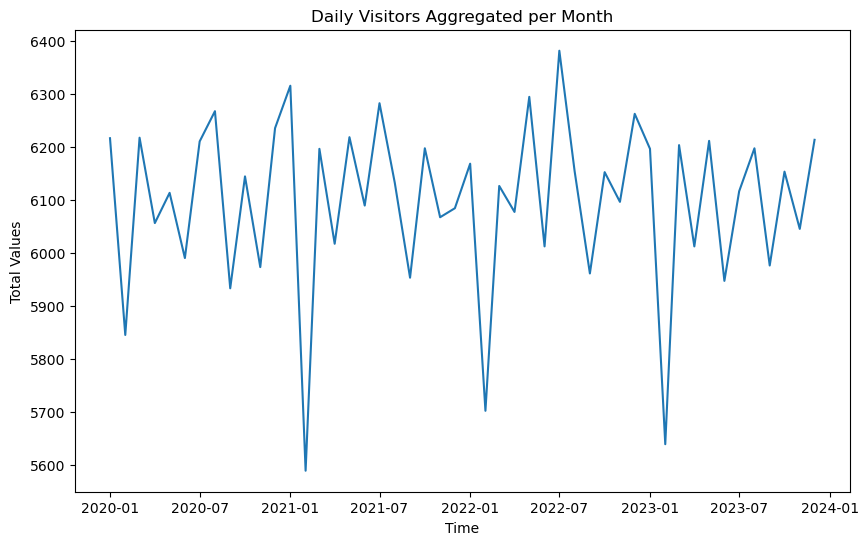

In [20]:
#Create a time series graphs of aggregated data based on the month
scatter(website_monthly_sum.index,website_monthly_sum['Daily Visitors'],'Daily Visitors Aggregated per Month','Time','Total Values')

The aggregated data that is summed based on the month of the datetime, shows more of a cycle and this will be the data that is going to be used in the exploratory data analysis

## 1.2 Exploratory Data Analysis:
1. Visualize the data to understand trends, seasonality, and other characteristics.

2. Decompose the series to observe its components: trend, seasonality, and residuals.

### Visualise the data

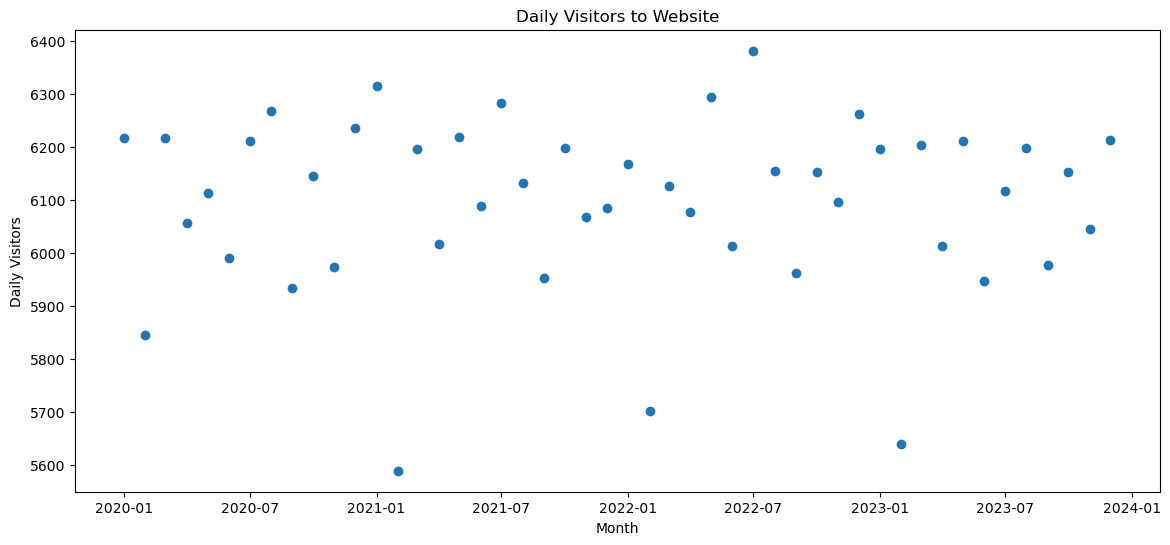

In [21]:
#Plot the time series graph of website visits data
time_series(website_monthly_sum.index,website_monthly_sum['Daily Visitors'],'Daily Visitors to Website','Month','Daily Visitors')

### Exploration of Seasonal Decomposition for website

#### Seasonality Period Decision
The seasonality does not become very apparent so using the following methods, a seasonal value is going to be determined
1. Data Visualisation - Taking the rolling mean
2. ACF & PACF Plot

#### 1. Data Visualisation 
Look at the rolling average of the data to try and identify trends in the data which might lead to a better understanding seasonal time period.

<Figure size 1000x600 with 0 Axes>

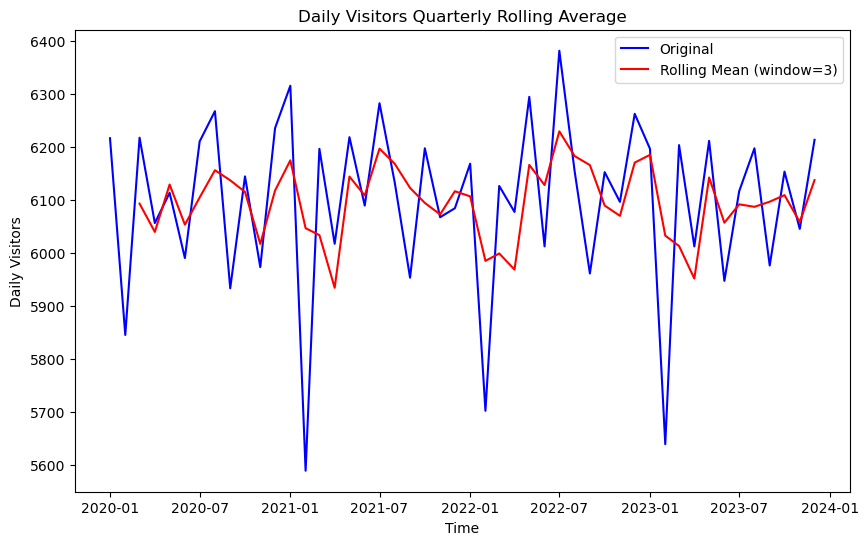

In [22]:
#Plot the rolling mean graph
roll_mean(website_monthly_sum['Daily Visitors'],3,'Daily Visitors Quarterly Rolling Average','Time','Daily Visitors')

There does seem to be some type of oscillations that take place when you look at the quarterly rolling average.

#### 2. ACF & PACF Plots
Looking at the ACF and PACF plots is going to give insight for different things

1. ACF plot - Is looking at the moving average nature of the graph, this is how much values from lag k-1 impact lag k.

2. PACF plot - Is looking at the autoregressive nature of the graph, this is how values from lag k impact the current value

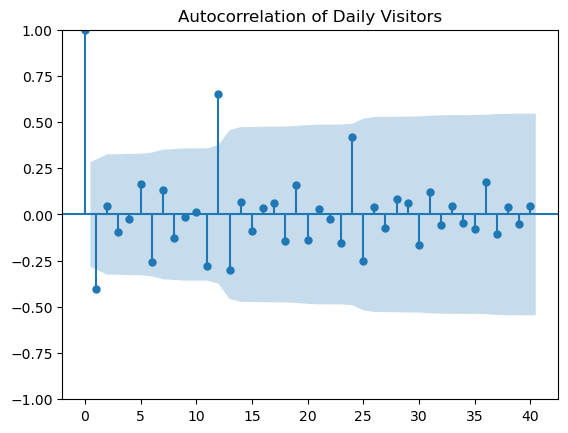

In [23]:
#Look at the acf plot to determine the moving average
website_monthly_sum_acf = plot_acf(website_monthly_sum['Daily Visitors'],lags=40,title='Autocorrelation of Daily Visitors')

You can observe the spike of autocorrelation at lag 12.

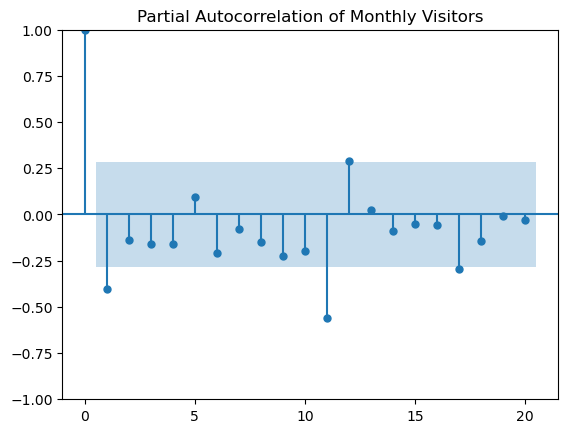

In [24]:
#Look at the acf plot to determine the moving average
website_monthly_sum_pacf = plot_pacf(website_monthly_sum['Daily Visitors'],lags=20,title='Partial Autocorrelation of Monthly Visitors')

There is a spike at 12 again, I am going to use this as the seasonality value

### Seasonal Decomposition of Website Daily Visitors
Using a period of 12 for the monthly summed data this is going to assume that the season is a year.

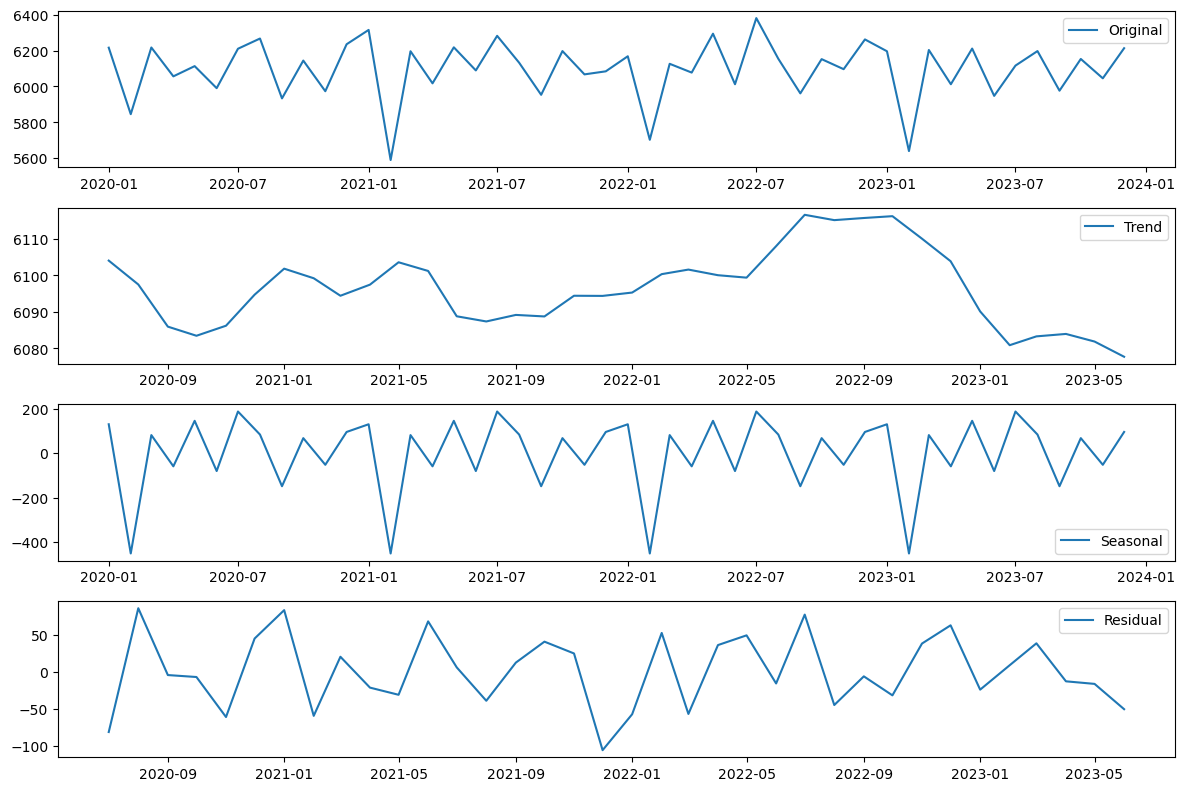

In [25]:
#Create a variable which can be referrenced to get the different series below
#Plot the decomposition with a period of a year as the seasonality 
website_seasonal_decomposition = decompose_seasonality(website_monthly_sum['Daily Visitors'],12)
plot_seasonal_decomposition(website_monthly_sum['Daily Visitors'],12)

#### Trend of Website Decomposition
You can see that the difference is an extremely small movement so there is no overall change in values based on the time change

#### Seasonal of Website Decomposition
There is a seasonal value is quite small again, so it does not represent that signifigant of changes based upon the time of the year the data was recorded.

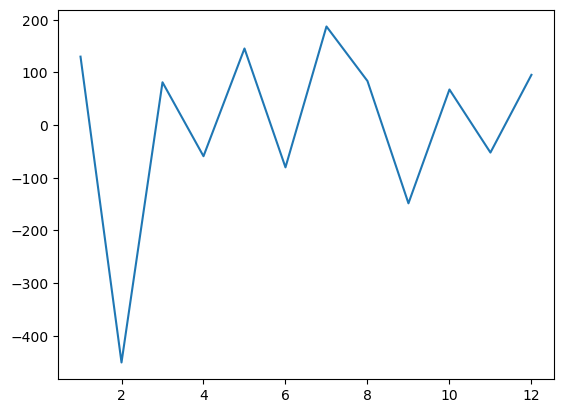

In [26]:
#Create a dataframe for the first year of the seasonality
#This will return 12 values 
#You can observe the seasonality by itself 
months_list = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
website_seasonal_values = pd.DataFrame(website_seasonal_decomposition[2].iloc[0:12])
website_seasonal_values['Incrementing Month'] = range(1, len(website_seasonal_values)+1)
plt.plot(website_seasonal_values['Incrementing Month'],website_seasonal_values['seasonal'])

You can see that during February of a calendar year the value is going to drop down before returning to inconsistient spikes and dips around a mean of 0.

#### Residual of Website Decomposition

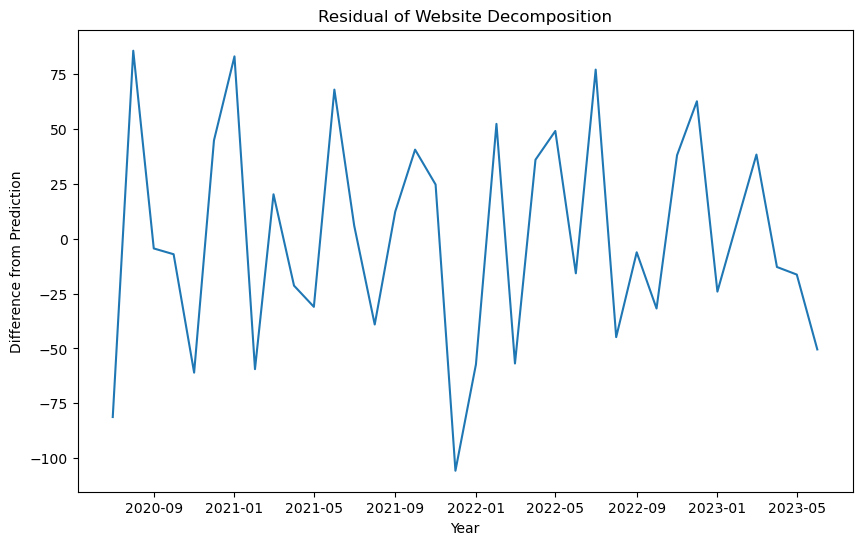

In [27]:
#Plot the residual of websites
time_series(website_seasonal_decomposition[3].index,website_seasonal_decomposition[3],'Residual of Website Decomposition','Year','Difference from Prediction')

Comparison of the axes of the seasonality graph and of the residual shows how the seasonality value is not that accurate. The differences almost match the residual difference which suggests that there is no real seasonality going on. This would be consistient with the fact that the model is stationary.

## 1.3 ARIMA Model Building:

1. Determine the order of differencing (d) needed to make the series stationary.

2. Identify the autoregressive term (p) and moving average term (q) using plots such as the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

3. Construct and fit the ARIMA model to the historical data.

#### ARIMA Modeling
The following ARIMA modeling types are going to be explored
- AR: Autoregressive Model (p value - using PACF to find order)
- MA: Moving Average Model (q value - using ACF to find order)
- ARMA: Autoregressive Moving Average (p value, q value)
- ARIMA: Autoregressive Integrated Moving Average (p value, d value, q value)

#### p,d,q orders value

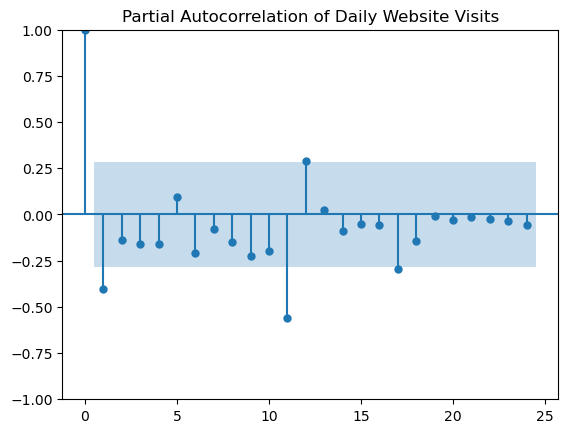

In [28]:
#Use the pacf plot to find the p order
website_monthly_sum_pacf = plot_pacf(website_monthly_sum['Daily Visitors'],title='Partial Autocorrelation of Daily Website Visits',lags=24)

In [29]:
#Create a list of p orders
p_orders_value = [1,11,12]

In [30]:
#Look at the ADF statistic to determine the d value
adf_test(website_monthly_sum['Daily Visitors'])

ADF Statistic:  -6.230698158447822
P-Value:  4.9617716583331424e-08
Critical Value: 
	1%: -3.62
	5%: -2.94
	10%: -2.61


In [31]:
#Create a list of d orders
d_orders_value = [0,1]

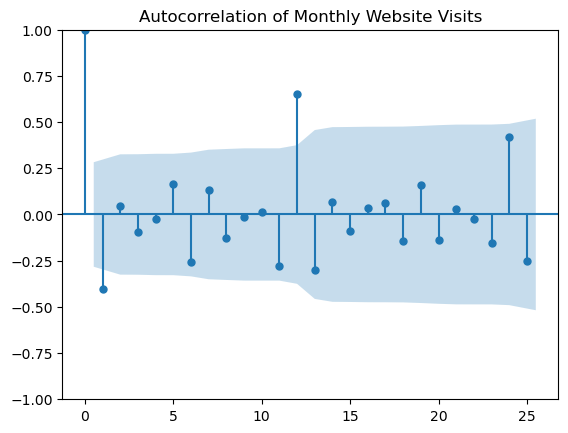

In [32]:
#Look at the ACF plot to find q
website_monthly_sum_acf = plot_acf(website_monthly_sum['Daily Visitors'],title='Autocorrelation of Monthly Website Visits',lags=25)

In [33]:
#Create a list of q orders
q_orders_value = [1,12,24]

#### P,D,Q Values
Take the seasonality values out of the data so that pacf,acf and adf statistics can be done to figure out the P,D,Q values

In [34]:
#Remove seasonal variations from data
website_seasonally_adjusted = website_seasonal_decomposition[0] - website_seasonal_decomposition[2]
website_seasonally_adjusted

Date
2020-01-01    6086.015046
2020-02-01    6295.737269
2020-03-01    6135.695602
2020-04-01    6115.084491
2020-05-01    5967.542824
                 ...     
2023-08-01    6113.265046
2023-09-01    6124.542824
2023-10-01    6085.403935
2023-11-01    6097.153935
2023-12-01    6117.584491
Length: 48, dtype: float64

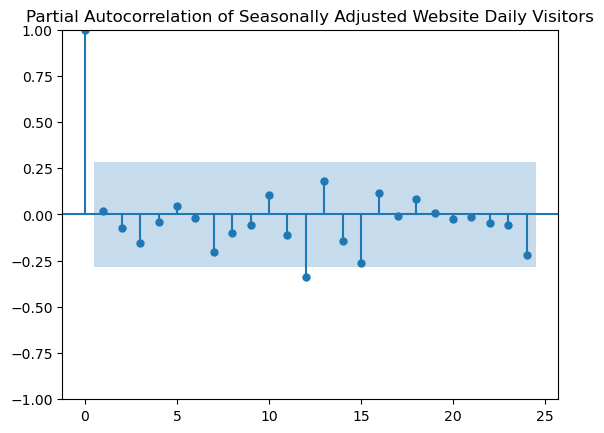

In [35]:
#Use the PACF to find P values
website_seasonally_adjusted_pacf = plot_pacf(website_seasonally_adjusted,lags=24,title='Partial Autocorrelation of Seasonally Adjusted Website Daily Visitors')

In [36]:
#List of P orders
P_orders_value = [12,24]

In [37]:
#Use the ADF statistic to solve for D list
adf_test(website_seasonally_adjusted)

ADF Statistic:  -3.0256856463231645
P-Value:  0.03256431803499405
Critical Value: 
	1%: -3.61
	5%: -2.94
	10%: -2.61


In [38]:
#D orders values
D_orders_value = [0,1]

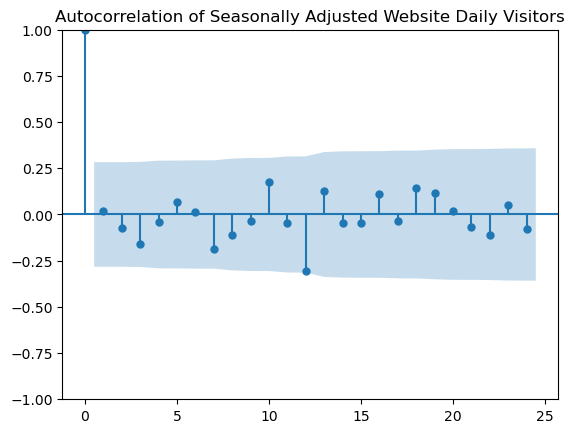

In [39]:
#Use the ACF to find Q values
website_seasonally_adjusted_acf = plot_acf(website_seasonally_adjusted,lags=24,title='Autocorrelation of Seasonally Adjusted Website Daily Visitors')

In [40]:
#Q orders value list
Q_orders_value = [12]

#### ARIMA Model Evaluation
Using the function above, there is going to be an ordered list of most effective (using AIC) order for different models.

In [41]:
evaluate_time_series_models(website_monthly_sum['Daily Visitors'],p_orders_value,q_orders_value,d_orders_value)

,Model,Order,AIC,BIC
30,ARIMA,"(12, 1, 1)",595.233398,621.135464
24,ARIMA,"(11, 1, 1)",596.082955,620.134874
2,AR,"(12, 0, 0)",598.618172,624.814986
27,ARIMA,"(12, 0, 1)",600.446674,628.514689
12,ARMA,"(12, 0, 1)",600.446674,628.514689
9,ARMA,"(11, 0, 1)",602.326103,628.522917
21,ARIMA,"(11, 0, 1)",602.326103,628.522917
1,AR,"(11, 0, 0)",609.655408,633.981021
18,ARIMA,"(1, 1, 1)",614.966322,620.516765
6,ARMA,"(1, 0, 1)",616.132897,623.617701


In [43]:
select_best_sarima_model(website_monthly_sum['Daily Visitors'],p_orders_value,d_orders_value,q_orders_value,P_orders_value,D_orders_value,Q_orders_value,12)

{'aic': 602.34679553842,
 'bic': 609.8315995820516,
 'pdq': (0, 0, 1),
 'seasonal_pdq': (0, 0, 1, 12)}

The values are 0 for both p and d as the data is stationary and has no autoregressive (moving average) and no need to difference data (d) as it is stationary.

## 1.4 Forecasting:
1. Forecast the future for what seems reasonable based upon the data.

2. Plot the predictions against the actual data (if available) to visualize the forecast's accuracy.

## 1.5 Model Evaluation
1. Use metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and others to evaluate the model.

2. Discuss the model's limitations and any discrepancies observed between the predicted and actual values.